In [1]:
import random
from pycaret.classification import *
from sklearn.utils import shuffle
import random
from pycaret.classification import *
from sklearn.utils import shuffle
from yellowbrick.style import set_palette
from yellowbrick.classifier import ROCAUC
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
from functools import reduce

In [2]:
# Model with dap-seq features
# Import T/F data
at_df = pd.read_csv("model_data/Model_input_data.tsv", sep="\t", header=0,index_col=0)
at_df_T = at_df[at_df.deg == 1].reset_index(drop=True)
at_df_F = at_df[at_df.deg == 0].reset_index(drop=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8421,0.8667,0.8000,0.8889,0.8421,0.6851,0.6889
1,0.7895,0.8722,0.8000,0.8000,0.8000,0.5778,0.5778
2,0.7895,0.7889,0.7778,0.7778,0.7778,0.5778,0.5778
3,0.7368,0.8333,0.6667,0.7500,0.7059,0.4693,0.4719
4,0.4211,0.4944,0.2222,0.3333,0.2667,-0.1808,-0.1910
5,0.7895,0.8222,0.6667,0.8571,0.7500,0.5730,0.5866
6,0.7895,0.7500,0.7778,0.7778,0.7778,0.5778,0.5778
7,0.7368,0.7889,0.7778,0.7000,0.7368,0.4751,0.4778
8,0.8421,0.9278,1.0000,0.7500,0.8571,0.6885,0.7246


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8872,0.9476,0.8897,0.8462,0.8674,0.7693,0.7701


Text(0, 0.5, 'True positive rate')

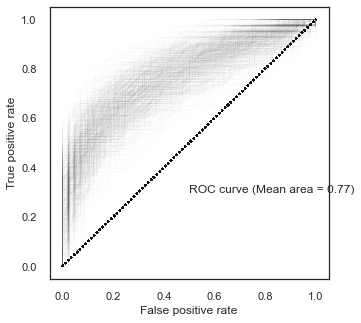

In [65]:
# Generate balance data and test set with multiple random_state value
balance_index = random.sample(range(100,1000),500)
test_set_index = random.sample(range(100,1000),500)
sns.set_theme(style="white")
# Randomly withdraw the dataset for 500 times
# Get the results of prediction for 500 times
AUC_list=[]
y_test_all=[]
proba_all=[]
Accuracy_list=[]
F1_list=[]
Recall_list=[]
importance_feature_list=[]
all_pre_list = []

# Plot the AUC curves of 500 times
plt.figure(figsize=(5, 5)) 
for i in range(500):
    at_df_F_use = at_df_F.sample(len(at_df_T),
                                 random_state = balance_index[i]).reset_index(drop=True)
    at_df_balance = at_df_T.append(at_df_F_use).reset_index(drop=True)
    gene_names=at_df.index
    at_df_label = at_df_balance['deg']
    at_df_balance_cor_15 = at_df_balance[at_df_balance.corr().deg[
        abs(at_df_balance.corr().deg) > 0.1].index]
    at_df_cor_15 = at_df[at_df_balance.corr().deg[
        abs(at_df_balance.corr().deg) > 0.1].index]
    TF_classify_balance_cor = setup(data=at_df_balance_cor_15,
                                    target='deg',
                                    silent=True,
                                    train_size=0.7,
                                    fold=10,
                                    normalize=True,
                                    normalize_method='zscore',
                                    feature_selection=True,
                                    pca=False,
                                    session_id=test_set_index[i],
                                    html=True)

    best_model = create_model('rf')
    results=pull()
    AUC_list.append(results.AUC.array[0])
    Accuracy_list.append(results.Accuracy.array[0])
    F1_list.append(results.F1.array[0])
    Recall_list.append(results.Recall.array[0])
    X_train = get_config('X_train')
    y_train = get_config('y_train')
    X_test = get_config('X_test')
    y_test = get_config('y_test')
    final_model = finalize_model(best_model)
    prediction = predict_model(best_model,data = at_df_cor_15,raw_score= True)
    pre_score = prediction.Score_1
    all_pre_list.append(pre_score)
    visualizer = ROCAUC(best_model, micro=False,macro=False,per_class=False,kwargs = {'classes_': {'color': 'darkgray'}})
    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)
    
    # Get important features from models
    importance = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(best_model.feature_importances_)}).sort_values(by='Value', ascending=False).reset_index(drop=True)
    importance_feature = importance.iloc[4:14,].reset_index(drop=True)
    importance_feature_names =  importance_feature.iloc[:,0]
    importance_feature_names_split_list =list(map(lambda x :x.split("_")[:-1],list(importance_feature_names)))
    importance_feature_top_10 = list(map(lambda string:reduce(lambda x,y:x+'_'+y,string),importance_feature_names_split_list))
    importance_feature_list.append(importance_feature_top_10)
mean_auc = sum(AUC_list)/len(AUC_list)
plt.text(0.5,0.3,'ROC curve (Mean area = %.2f)' % mean_auc)
plt.xlabel("False positive rate")
plt.ylabel('True positive rate')
#plt.savefig("AUC.pdf",dpi=1000)

In [55]:

from collections import Counter
importance_feature_all=reduce(lambda x,y:x+y,importance_feature_list)
importance_feature_table = Counter(importance_feature_all)
importance_feature_df = pd.DataFrame()
importance_feature_df['names'] = importance_feature_table.keys()
importance_feature_df['count'] = importance_feature_table.values()
importance_feature_df['count'] = importance_feature_df['count']/500
importance_feature_df = importance_feature_df.sort_values(by='count', ascending=False).reset_index(drop=True)
importance_feature_df.iloc[:20,]
importance_feature_names =  importance_feature_df['names']
importance_feature_names_split_list =list(map(lambda x :x.split("_"),list(importance_feature_names)))
importance_feature_df['names'] = list(map(lambda string:reduce(lambda x,y:x+' '+y,string),importance_feature_names_split_list))
importance_feature_df = importance_feature_df.iloc[:20,]

0.6983083999999972
0.6891857999999995
0.6852906000000004


In [77]:
# Prediction results
pre_mean = []
for i in range(len(all_pre_list[1])):
    gene_mean = []
    for j in range(500):
        gene_mean.append(all_pre_list[j][i])
    pre_mean.append(sum(gene_mean)/500)
pre_result = pd.DataFrame({'gene': at_df.index,'prediction':pre_mean,'label':at_df['deg']})
with open("MODEL_prediction","w") as f:
    for n in range(327):
        f.writelines(str(pre_result.gene[n])+'\t'+str(pre_result.prediction[n])+'\t'+str(pre_result.label[n])+'\n')

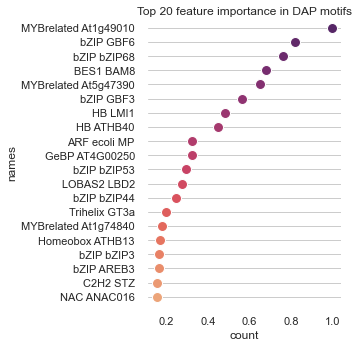

In [56]:
# Plot feature importance
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context({'figure.figsize':[5, 5]})
feature_plot=sns.stripplot(x="count", y="names", data=importance_feature_df,
              size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")
feature_plot.set(title = "Top 20 feature importance in DAP motifs")
feature_plot.xaxis.grid(False)
feature_plot.yaxis.grid(True)
sns.despine(left=True, bottom=True)
fig = feature_plot.get_figure()
fig.tight_layout()
fig.savefig("Feature importance top20.pdf",dpi=1000)

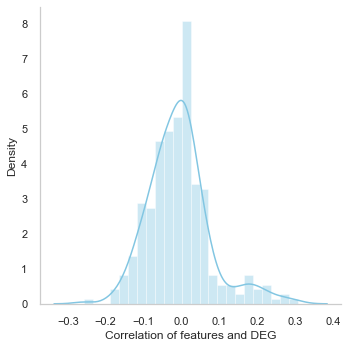

In [13]:
# Plot correlation between deg and features
import seaborn as sns
import matplotlib.pyplot as plt
cor_deg = at_df.corr().deg
del cor_deg['deg']
sns.set_context({'figure.figsize':[5, 5]})
color=sns.color_palette("muted")
sns.set_theme(style="whitegrid",palette=color[9:])
ax = sns.distplot(cor_deg)
ax.set_xlabel('Correlation of features and DEG',
              fontweight='normal',
              fontsize=12)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig=ax.get_figure()
fig.tight_layout()
fig.savefig("Feature correlation.pdf",dpi=1000)

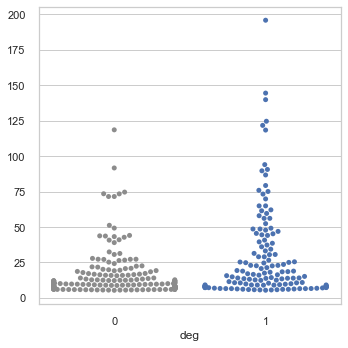

In [40]:
# Other features have impact on DEG
# Signal
sns.set_context({'figure.figsize':[5, 5]})
color=[sns.color_palette("deep")[7],sns.color_palette("deep")[0]]
Signal = list(at_df.iloc[:,309])
#+list(at_df.iloc[:,310])
deg = list(at_df.iloc[:,308])
#*2
#GLK = ['GLK1']*328+['GLK2']*328
plt_data = {'Signal':Signal,'deg':deg}
#            ,'GLK':GLK}
plt_data = pd.DataFrame(plt_data)
sns.set_theme(style="whitegrid", palette=color)
ax = sns.swarmplot(data=plt_data, x="deg", y="Signal")
ax.set(ylabel="")
fig=ax.get_figure()
fig.tight_layout()
fig.savefig("Signal in DEG.pdf",dpi=1000)
plt_data

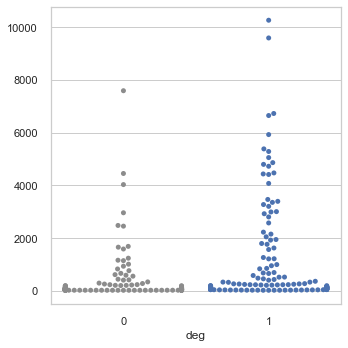

In [32]:
# FPKM
sns.set_context({'figure.figsize':[5, 5]})
FPKM_data = at_df.iloc[:,[308,311]]
FPKM_data = FPKM_data.drop('AT2G41870')
color=[sns.color_palette("deep")[7],sns.color_palette("deep")[0]]
sns.set_theme(style="whitegrid", palette=color)
ax2 = sns.swarmplot(data=FPKM_data, x="deg", y="fpkm")
ax2.set(ylabel="")
fig=ax2.get_figure()
fig.tight_layout()
fig.savefig("FPKM in DEG.pdf",dpi=1000)

In [ ]:
# Distance to genes
sns.set_context({'figure.figsize':[5,5]})
distance_data = at_df.iloc[:,[308,312]]
sns.set_theme(style="whitegrid", palette=color)
ax3 = sns.swarmplot(data=distance_data, x="deg", y="distance")
ax3.set(ylabel="")
fig=ax3.get_figure()
fig.tight_layout()
fig.savefig("Distance in DEG.pdf",dpi=1000)